In [1]:
from math import exp, sqrt, log
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

from dictances import cosine
from dictances import bhattacharyya
from dictances import bhattacharyya_coefficient
from dictances import jensen_shannon
from dictances import kullback_leibler
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from pydiffmap import diffusion_map as dm
from pydiffmap.visualization import embedding_plot, data_plot

from ref.Shir import utils

In [16]:
from ref.Diffusion_Maps import diffusionMapping

# Data From - https://archive.ics.uci.edu/ml/datasets/glass+identification

In [2]:
pd.set_option('display.max_columns', None)
df_glass = pd.read_csv('data/glass.csv')
df_glass.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df_glass.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [4]:
df_glass['label'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: label, dtype: int64

In [5]:
def JM_distance(p, q):
    b= bhattacharyya_distance(p, q)
    jm = 2 * (1-np.exp(-b))
    return jm

def min_max_scaler(df, features):
    scaler = preprocessing.MinMaxScaler()
    numpy_norm = scaler.fit_transform(df[features])    
    df_norm = pd.DataFrame(numpy_norm, columns=features)
    df_norm['label'] = df['label'].values
    return df_norm



def hellinger(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension
    """
    list_of_squares = []
    for p_i, q_i in zip(p, q):

        # caluclate the square of the difference of ith distr elements
        s = (sqrt(p_i) - sqrt(q_i)) ** 2

        # append 
        list_of_squares.append(s)

    # calculate sum of squares
    sosq = sum(list_of_squares)    

    return sosq / sqrt(2)

In [6]:
def bhattacharyya_distance(p, q):
    mean_p, mean_q = p.mean(), q.mean()
    std_p = p.std() if p.std() != 0 else 0.00000000001
    std_q = q.std() if q.std() != 0 else 0.00000000001
    
    var_p, var_q = std_p**2, std_q**2
    b = (1/8) * ((mean_p - mean_q)**2) * (2/(var_p + var_q)) + 0.5 * np.log((var_p + var_q)/(2 * (std_p * std_q)))
    return b

In [7]:
def wasserstein_dist(df, feature, label1, label2):
    dist= wasserstein_distance(df.loc[df['label']==label1, feature], df.loc[df['label']==label2, feature])
    return dist

def bhattacharyya_dist(df, feature, label1, label2):
#     dist = bhattacharyya(df.loc[df['label']==label1, feature], df.loc[df['label']==label2, feature])
    dist= bhattacharyya_distance(df.loc[df['label']==label1, feature], df.loc[df['label']==label2, feature])
    return dist

def jensen_shannon_dist(df, feature, label1, label2):
    dist= jensen_shannon(df.loc[df['label']==label1, feature], df.loc[df['label']==label2, feature])
    return dist

def hellinger_dist(df, feature, label1, label2):
    dist= hellinger(df.loc[df['label']==label1, feature], df.loc[df['label']==label2, feature])
    return dist

def jm_dist(df, feature, label1, label2):
    dist= JM_distance(df.loc[df['label']==label1, feature], df.loc[df['label']==label2, feature])
    return dist

def flatten(t):
    return [item for sublist in t for item in sublist]

def execute_function(df, function_name, feature, label1, label2):
    return {
        'wasserstein_dist': lambda: wasserstein_dist(df, feature, label1, label2),
        'bhattacharyya_dist': lambda: bhattacharyya_dist(df, feature, label1, label2),
        'jensen_shannon_dist': lambda: jensen_shannon_dist(df, feature, label1, label2),
        'hellinger_dist': lambda: hellinger_dist(df, feature, label1, label2),
        'jm_dist': lambda: jm_dist(df, feature, label1, label2)
    }[function_name]()

In [8]:
def calc_dist(dist_func_name, df, target_col):
    """
    Calculates distances of each feature w/ itself in different target classses 
    for each DataFrame & distance functions
    
    return: df_dists, dist_dict
    df_dists - a flatten df of all features (each feature is a row)
    dist_dict - a dictionary of feature names & dataframes (e.g. {'feature_1': feature_1_df, ...}
    """
    features = df.columns.drop(target_col)
    classes = df[target_col].unique()
    distances = []
    for feature in features:
        class_dist = []
        for cls_feature1 in classes:    
            class_row = [execute_function(df, dist_func_name, feature, cls_feature1, cls_feature2) for cls_feature2 in classes]
            class_dist.append(class_row)
        distances.append(class_dist)
    
    two_d_mat = [flatten(distances[idx]) for idx in range(len(distances))]
    df_dists = pd.DataFrame(two_d_mat)
    dist_dict = {f'feature_{idx+1}': pd.DataFrame(mat) for idx, mat in enumerate(distances)}
    return df_dists, dist_dict

In [9]:
def calc_mean_std(feature_mat):
    mean = feature_mat.mean().mean()
    var = sum([((x - mean) ** 2) for x in flatten(feature_mat.values)]) / len(flatten(feature_mat.values))
    std = var**0.5
    return mean, std

In [10]:
def norm_by_dist_type(feature_mat):
    mean, std = calc_mean_std(feature_mat)
    norm_feature_mat = (feature_mat-mean)/std
    return norm_feature_mat

def export_heatmaps(df, features, dist_type1, dist_type2, to_norm):
    assert dist_type1 in ('wasserstein_dist', 'bhattacharyya_dist', 'jensen_shannon_dist', 'hellinger_dist', 'jm_dist')
    assert dist_type2 in ('wasserstein_dist', 'bhattacharyya_dist', 'jensen_shannon_dist', 'hellinger_dist', 'jm_dist')
    _, dist_dict1 = calc_dist(dist_type1, df, 'label')
    _, dist_dict2 = calc_dist(dist_type2, df, 'label')
    
    cols = [dist_type1, dist_type2]
    rows = ['feature {}'.format(row) for row in features]
    fig, axes = plt.subplots(nrows=len(features),ncols=2, figsize=(8, 25))

    for i ,feature  in zip(range(len(rows)),features):
        feature_mat1 = dist_dict1[feature]
        feature_mat2 = dist_dict2[feature]
        if to_norm:
            feature_dist_mat1 = norm_by_dist_type(feature_mat1)
            feature_dist_mat2 = norm_by_dist_type(feature_mat2)
        else:
            feature_dist_mat1 = feature_mat1
            feature_dist_mat2 = feature_mat2
        sns.heatmap(feature_dist_mat1, annot=True,  linewidths=.5, ax = axes[i,0])
        sns.heatmap(feature_dist_mat2, annot=True,  linewidths=.5,ax = axes[i,1])
        
    for axc, col in zip(axes[0], cols):
            axc.set_title(col)   
    
    for axr, row in zip(axes[:,0], rows):      
        axr.set_ylabel(row, rotation=90, size='large')
    
    plt.show()

# Feature HeatMaps w/ distance

# Feature HeatMaps w/ distance normalization

In [11]:
features = df_glass.columns.tolist()[:-1]
df_norm = min_max_scaler(df_glass, features)

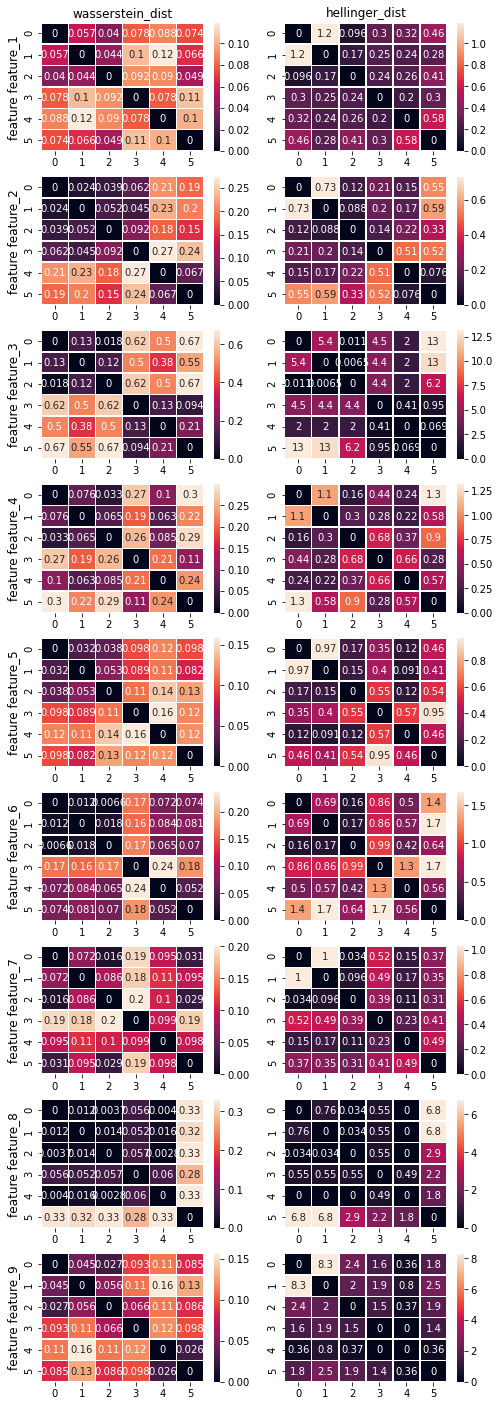

In [50]:
export_heatmaps(df_norm, features, 'wasserstein_dist', 'hellinger_dist', False)

export_heatmaps(df_norm, features, 'wasserstein_dist', 'jensen_shannon_dist', False)

export_heatmaps(df_norm, features, 'jm_dist', 'hellinger_dist', False)

export_heatmaps(df_norm, features, 'bhattacharyya_dist', 'hellinger_dist', False)

In [94]:
df_dists_wasser, dist_dict_wasser = calc_dist('wasserstein_dist', df_norm, 'label')
df_dists_wasser.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.0,0.057404,0.039554,0.077971,0.088249,0.074416,0.057404,0.0,0.044238,0.104490,0.119250,0.065950,0.039554,0.044238,0.0,0.091602,0.090029,0.049388,0.077971,0.104490,0.091602,0.0,0.077996,0.106090,0.088249,0.119250,0.090029,0.077996,0.0,0.101465,0.074416,0.065950,0.049388,0.106090,0.101465,0.0
1,0.0,0.023715,0.038668,0.062345,0.211185,0.186290,0.023715,0.0,0.051571,0.045014,0.230820,0.200054,0.038668,0.051571,0.0,0.091634,0.181896,0.153307,0.062345,0.045014,0.091634,0.0,0.273530,0.242763,0.211185,0.230820,0.181896,0.273530,0.0,0.066984,0.186290,0.200054,0.153307,0.242763,0.066984,0.0
2,0.0,0.126256,0.017595,0.618838,0.500417,0.671303,0.126256,0.0,0.124980,0.496272,0.377851,0.548737,0.017595,0.124980,0.0,0.616856,0.498435,0.669322,0.618838,0.496272,0.616856,0.0,0.127672,0.093866,0.500417,0.377851,0.498435,0.127672,0.0,0.210361,0.671303,0.548737,0.669322,0.093866,0.210361,0.0
3,0.0,0.076106,0.033260,0.271025,0.103264,0.298723,0.076106,0.0,0.064644,0.194918,0.062861,0.222617,0.033260,0.064644,0.0,0.259399,0.085476,0.287097,0.271025,0.194918,0.259399,0.0,0.207844,0.110480,0.103264,0.062861,0.085476,0.207844,0.0,0.235543,0.298723,0.222617,0.287097,0.110480,0.235543,0.0
4,0.0,0.031805,0.038436,0.097747,0.117018,0.097753,0.031805,0.0,0.053443,0.089486,0.113343,0.082499,0.038436,0.053443,0.0,0.110601,0.143207,0.128792,0.097747,0.089486,0.110601,0.0,0.157906,0.117947,0.117018,0.113343,0.143207,0.157906,0.0,0.121326,0.097753,0.082499,0.128792,0.117947,0.121326,0.0
5,0.0,0.012137,0.006609,0.168052,0.072050,0.074282,0.012137,0.0,0.018451,0.161298,0.083905,0.080751,0.006609,0.018451,0.0,0.173010,0.065454,0.069815,0.168052,0.161298,0.173010,0.0,0.236715,0.184352,0.072050,0.083905,0.065454,0.236715,0.0,0.052363,0.074282,0.080751,0.069815,0.184352,0.052363,0.0
6,0.0,0.072304,0.015714,0.191095,0.094874,0.030739,0.072304,0.0,0.086486,0.184064,0.112750,0.095329,0.015714,0.086486,0.0,0.200945,0.104672,0.029208,0.191095,0.184064,0.200945,0.0,0.099355,0.185745,0.094874,0.112750,0.104672,0.099355,0.0,0.098420,0.030739,0.095329,0.029208,0.185745,0.098420,0.0
7,0.0,0.012221,0.003663,0.055549,0.004036,0.326122,0.012221,0.0,0.013809,0.051565,0.015957,0.316458,0.003663,0.013809,0.0,0.056784,0.002801,0.327358,0.055549,0.051565,0.056784,0.0,0.059585,0.283929,0.004036,0.015957,0.002801,0.059585,0.0,0.330159,0.326122,0.316458,0.327358,0.283929,0.330159,0.0
8,0.0,0.044582,0.027072,0.092502,0.111765,0.085396,0.044582,0.0,0.055940,0.110264,0.156347,0.129978,0.027072,0.055940,0.0,0.066188,0.111880,0.085511,0.092502,0.110264,0.066188,0.0,0.119155,0.097779,0.111765,0.156347,0.111880,0.119155,0.0,0.026369,0.085396,0.129978,0.085511,0.097779,0.026369,0.0


In [95]:
df_dists_wasser.iloc[[5, 8], ]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
5,0.0,0.012137,0.006609,0.168052,0.072050,0.074282,0.012137,0.0,0.018451,0.161298,0.083905,0.080751,0.006609,0.018451,0.0,0.173010,0.065454,0.069815,0.168052,0.161298,0.173010,0.0,0.236715,0.184352,0.072050,0.083905,0.065454,0.236715,0.0,0.052363,0.074282,0.080751,0.069815,0.184352,0.052363,0.0
8,0.0,0.044582,0.027072,0.092502,0.111765,0.085396,0.044582,0.0,0.055940,0.110264,0.156347,0.129978,0.027072,0.055940,0.0,0.066188,0.111880,0.085511,0.092502,0.110264,0.066188,0.0,0.119155,0.097779,0.111765,0.156347,0.111880,0.119155,0.0,0.026369,0.085396,0.129978,0.085511,0.097779,0.026369,0.0


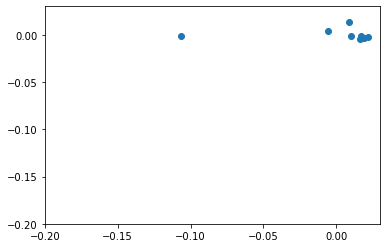

In [96]:
eps_type='maxmin'#mean' #or maxmin
alpha=1
vec_wasser, egs_wasser, coordinates_wasser, dataList_wasser, epsilon_wasser = diffusionMapping(df_dists_wasser, alpha, eps_type, 1, dim=2)

plt.xlim(-0.2, 0.03)
plt.ylim(-0.2, 0.03)
plt.scatter(coordinates_wasser[0], coordinates_wasser[1])

In [97]:
df_coordinates_wasser = pd.DataFrame(data=coordinates_wasser).T
df_coordinates_wasser.head(10)

,0,1
0,0.022150,-0.002634
1,0.010548,-0.000835
2,-0.106535,-0.001743
3,-0.005545,0.003992
4,0.017081,-0.001703
5,0.018330,-0.003216
6,0.016404,-0.004259
7,0.008966,0.013563
8,0.018971,-0.003165


In [98]:
def calculateDistance(p1,p2):
    dist = sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    return dist
dists = []
for index1, row1 in df_coordinates_wasser.iterrows():
    dists2 = [calculateDistance(row1, row2) for index2, row2 in df_coordinates_wasser.iterrows()]
    dists.append(dists2)
df_DM_dists_wasser = pd.DataFrame(dists)
df_DM_dists_wasser.head(10)

,0,1,2,3,4,5,6,7,8
0,0.000000,0.011741,0.128688,0.028476,0.005154,0.003864,0.005971,0.020885,0.003223
1,0.011741,0.000000,0.117086,0.016801,0.006591,0.008139,0.006784,0.014485,0.008740
2,0.128688,0.117086,0.000000,0.101153,0.123616,0.124874,0.122965,0.116511,0.125514
3,0.028476,0.016801,0.101153,0.000000,0.023331,0.024939,0.023449,0.017383,0.025539
4,0.005154,0.006591,0.123616,0.023331,0.000000,0.001962,0.002644,0.017289,0.002390
5,0.003864,0.008139,0.124874,0.024939,0.001962,0.000000,0.002190,0.019215,0.000643
6,0.005971,0.006784,0.122965,0.023449,0.002644,0.002190,0.000000,0.019313,0.002790
7,0.020885,0.014485,0.116511,0.017383,0.017289,0.019215,0.019313,0.000000,0.019492
8,0.003223,0.008740,0.125514,0.025539,0.002390,0.000643,0.002790,0.019492,0.000000


In [117]:
df_dists_jm, dist_dict_jm = calc_dist('jm_dist', df_norm, 'label')
df_dists_jm.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,0.0,0.124137,0.045902,0.073642,0.100648,0.113689,0.124137,0.0,0.217436,0.010006,0.047110,0.128110,0.045902,0.217436,0.0,0.171273,0.119659,0.073698,0.073642,0.010006,0.171273,0.0,0.053640,0.125661,0.100648,0.047110,0.119659,0.053640,0.0,0.023744,0.113689,0.128110,0.073698,0.125661,0.023744,0.0
1,0.0,0.051825,0.037232,0.186265,0.766630,0.816231,0.051825,0.0,0.108825,0.050228,0.688785,0.769003,0.037232,0.108825,0.0,0.282289,0.642906,0.617801,0.186265,0.050228,0.282289,0.0,0.777449,0.913305,0.766630,0.688785,0.642906,0.777449,0.0,0.110536,0.816231,0.769003,0.617801,0.913305,0.110536,0.0
2,0.0,0.810485,0.083255,1.779236,1.517310,1.770610,0.810485,0.0,1.022918,0.800039,0.474720,0.855601,0.083255,1.022918,0.0,1.826574,1.610544,1.818039,1.779236,0.800039,1.826574,0.0,0.067403,0.018531,1.517310,0.474720,1.610544,0.067403,0.0,0.116636,1.770610,0.855601,1.818039,0.018531,0.116636,0.0
3,0.0,0.173294,0.031994,0.824964,0.280668,1.191393,0.173294,0.0,0.097811,0.527901,0.157988,0.732448,0.031994,0.097811,0.0,0.657905,0.144372,0.991668,0.824964,0.527901,0.657905,0.0,0.273292,0.100953,0.280668,0.157988,0.144372,0.273292,0.0,0.502653,1.191393,0.732448,0.991668,0.100953,0.502653,0.0
4,0.0,0.028782,0.044281,0.291286,0.285249,0.163438,0.028782,0.0,0.080985,0.160378,0.178542,0.079936,0.044281,0.080985,0.0,0.340179,0.427189,0.288359,0.291286,0.160378,0.340179,0.0,0.135657,0.115069,0.285249,0.178542,0.427189,0.135657,0.0,0.023514,0.163438,0.079936,0.288359,0.115069,0.023514,0.0
5,0.0,0.029304,0.010720,1.157027,1.999984,0.484866,0.029304,0.0,0.068095,1.152621,1.999989,0.506056,0.010720,0.068095,0.0,1.132652,1.999979,0.436678,1.157027,1.152621,1.132652,0.0,1.999986,0.586045,1.999984,1.999989,1.999979,1.999986,0.0,1.999974,0.484866,0.506056,0.436678,0.586045,1.999974,0.0
6,0.0,0.524973,0.081689,0.712682,0.396872,0.162444,0.524973,0.0,0.772734,0.071995,0.045532,0.236650,0.081689,0.772734,0.0,0.939081,0.649530,0.385387,0.712682,0.071995,0.939081,0.0,0.120650,0.464907,0.396872,0.045532,0.649530,0.120650,0.0,0.190396,0.162444,0.236650,0.385387,0.464907,0.190396,0.0
7,0.0,0.677868,0.291565,0.980660,1.999945,1.445968,0.677868,0.0,1.111135,0.142100,1.999974,0.803586,0.291565,1.111135,0.0,1.324219,1.999918,1.637098,0.980660,0.142100,1.324219,0.0,1.999980,0.403742,1.999945,1.999974,1.999918,1.999980,0.0,1.999989,1.445968,0.803586,1.637098,0.403742,1.999989,0.0
8,0.0,0.028972,0.018122,0.142938,1.999981,0.529857,0.028972,0.0,0.011256,0.074073,1.999983,0.682854,0.018122,0.011256,0.0,0.064775,1.999982,0.620518,0.142938,0.074073,0.064775,0.0,1.999984,0.811188,1.999981,1.999983,1.999982,1.999984,0.0,1.999965,0.529857,0.682854,0.620518,0.811188,1.999965,0.0


In [119]:
eps_type='maxmin'#mean' #or maxmin
alpha=1
vec_jm, egs_jm, coordinates_jm, dataList_jm, epsilon_jm = diffusionMapping(df_dists_jm, alpha, eps_type, 1, dim=2)

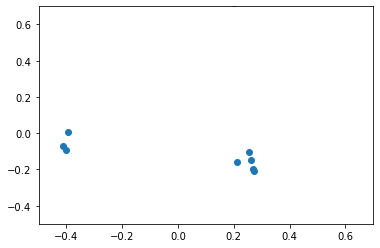

In [120]:
plt.xlim(-0.5, 0.7)
plt.ylim(-0.5, 0.7)
plt.scatter(coordinates_jm[0], coordinates_jm[1])

In [121]:
df_coordinates_jm = pd.DataFrame(data=coordinates_jm).T
df_coordinates_jm.head(10)

,0,1
0,0.272663,-0.208166
1,0.212139,-0.158056
2,0.200727,0.716942
3,0.252901,-0.101465
4,0.266770,-0.195646
5,-0.413761,-0.069082
6,0.259865,-0.146302
7,-0.396270,0.008116
8,-0.403388,-0.091435


In [122]:
dists = []
for index1, row1 in df_coordinates_jm.iterrows():
    dists2 = [calculateDistance(row1, row2) for index2, row2 in df_coordinates_jm.iterrows()]
    dists.append(dists2)
df_DM_dists_jm = pd.DataFrame(dists)
df_DM_dists_jm.head(10)

,0,1,2,3,4,5,6,7,8
0,0.000000,0.078576,0.927900,0.108515,0.013837,0.700373,0.063173,0.703029,0.686054
1,0.078576,0.000000,0.875072,0.069744,0.066314,0.632192,0.049152,0.630694,0.619121
2,0.927900,0.875072,0.000000,0.820068,0.914975,0.997712,0.865267,0.926736,1.009172
3,0.108515,0.069744,0.820068,0.000000,0.095197,0.667448,0.045375,0.658355,0.656366
4,0.013837,0.066314,0.914975,0.095197,0.000000,0.692200,0.049825,0.693643,0.678211
5,0.700373,0.632192,0.997712,0.667448,0.692200,0.000000,0.678037,0.079155,0.024643
6,0.063173,0.049152,0.865267,0.045375,0.049825,0.678037,0.000000,0.674061,0.665518
7,0.703029,0.630694,0.926736,0.658355,0.693643,0.079155,0.674061,0.000000,0.099805
8,0.686054,0.619121,1.009172,0.656366,0.678211,0.024643,0.665518,0.099805,0.000000


In [ ]:
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 1.0, alpha = 0.5, k=16)
dmap = mydmap.fit_transform(df_norm)

In [ ]:
embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'}) 
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'}) 
plt.show()

### PreProcess
Normalize the data

### Add Heatmap for each feature + heat scala

### 1st step - Embedding 
Over the feature matrix (6x6 / 4x4 / 3x3) - CNN
Over the feature row (1x36) - AutoEncoder
Over the flatenned matrix -  Random Projections / DM

### 2nd step - Diffusion Maps
DM over the encoded matrix (9x36-->9x2 for example)
DM from https://datafold-dev.gitlab.io/datafold/intro.html

### 3rd step - plot

